In [1]:
!pip install pandas
!pip install ipywidgets
!pip install matplotlib
!зip install reportlab

/bin/bash: line 1: зip: command not found


GridBox(layout=Layout(grid_template_columns='repeat(4, 200px)'))

Button(description='Remove', style=ButtonStyle())

File uploaded successfully!


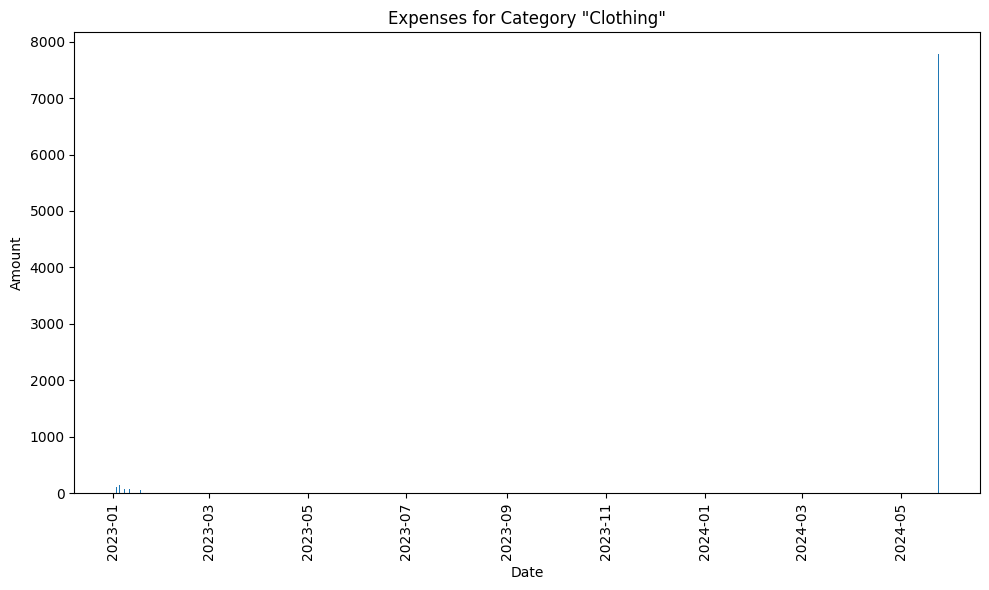

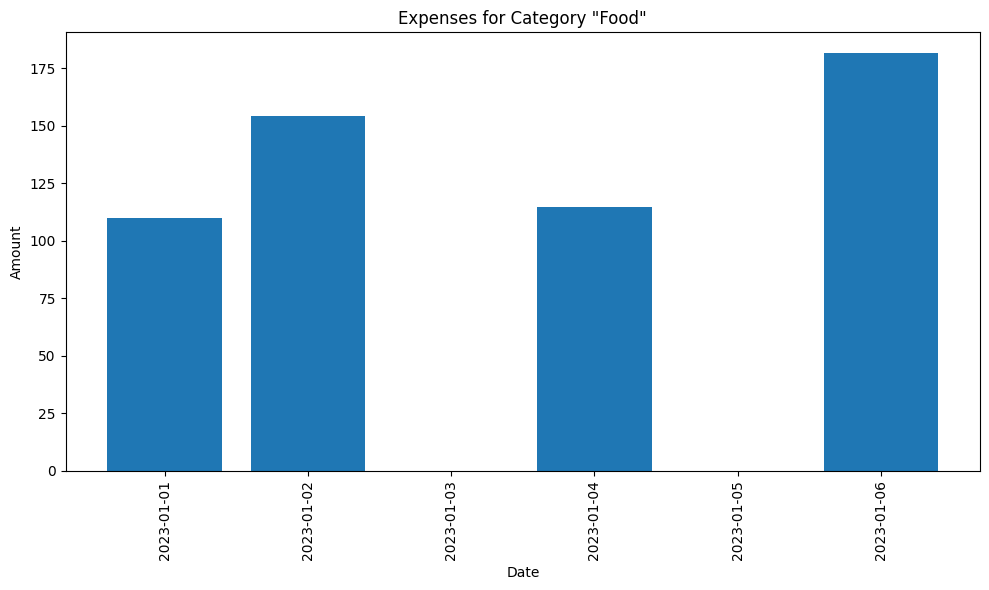

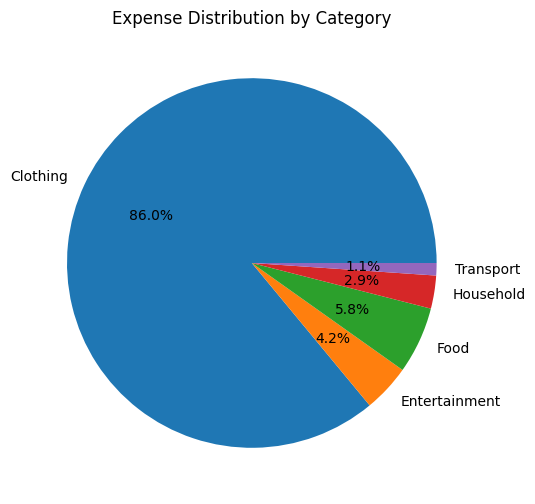

PDF report saved to file "expenses_report.pdf"


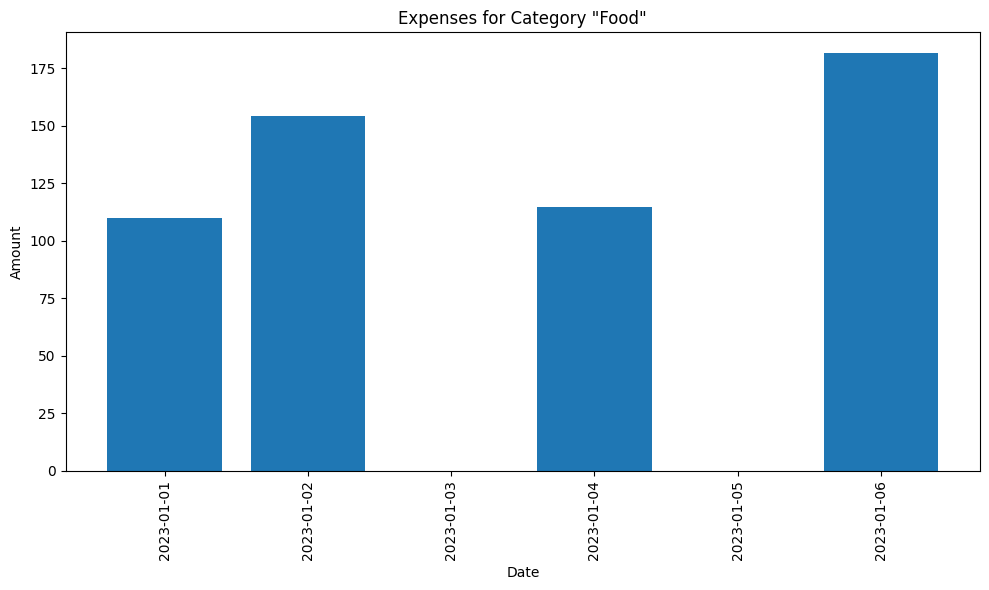

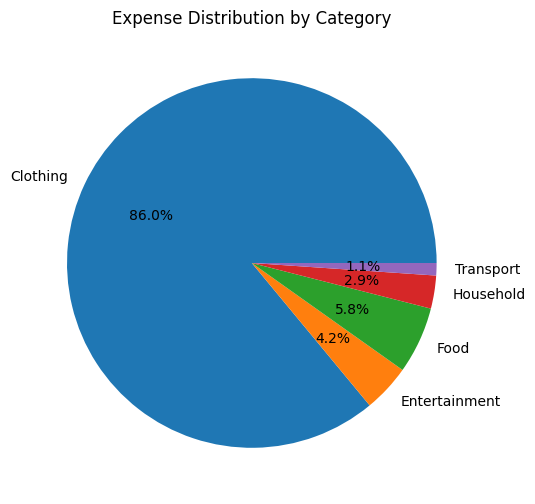

In [ ]:
import io
from datetime import datetime, timedelta
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Table, TableStyle, Paragraph, Image
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib import colors
from reportlab.pdfbase.ttfonts import TTFont
from reportlab.pdfbase import pdfmetrics

class Expense:
    def __init__(self, date, category, amount):
        self.date = date
        self.category = category
        self.amount = amount

    def __str__(self):
        return f"{self.date.strftime('%Y-%m-%d')} | {self.category} | {self.amount:.2f}"

class ExpenseManager:
    def __init__(self, default_category='Food'):
        self.expenses = []
        self.categories = ['Food', 'Clothing', 'Entertainment', 'Household', 'Transport']
        self.default_category = default_category

    def add_expense(self, date, category=None, amount=None):
        if category is None: category = self.default_category
        if amount is None: amount = 0
        
        self.expenses.append(Expense(date, category, amount))
        update_expense_list()

    def remove_expense(self, indices):
        indices = sorted(indices, reverse=True)
        for i in indices:
            del self.expenses[i]
        update_expense_list()

    def get_expenses_by_period(self, start_date, end_date):
        if isinstance(start_date, pd.Timestamp):
            start_date = start_date.date()
        else:
            start_date = start_date

        if isinstance(end_date, pd.Timestamp):
            end_date = end_date.date()
        else:
            end_date = end_date

        return [exp for exp in self.expenses if self.is_date_between(exp.date, start_date, end_date)]

    def is_date_between(self, date, start_date, end_date):
        if isinstance(date, pd.Timestamp):
            date = date.date()
        return start_date <= date <= end_date

    def get_expenses_by_category(self, category):
        return [exp for exp in self.expenses if exp.category == category]

    def total_expenses(self):
        return sum(exp.amount for exp in self.expenses)

    def sort_expenses(self, category_order, amount_order):
        category_order_reverse = category_order.copy()
        category_order_reverse.reverse()
        category_index = {category: i for i, category in enumerate(category_order)}
        self.expenses.sort(key=lambda x: (category_index[x.category], x.amount), reverse=amount_order)
        update_expense_list()

    def get_expenses_by_day(self):
        today = datetime.now().date()
        return self.get_expenses_by_period(today, today)

    def get_expenses_by_week(self):
        today = datetime.now().date()
        start_of_week = today - timedelta(days=today.weekday())
        return self.get_expenses_by_period(start_of_week, today)

    def get_expenses_by_month(self):
        today = datetime.now().date()
        start_of_month = today.replace(day=1)
        return self.get_expenses_by_period(start_of_month, today)

    def get_expenses_by_period_summary(self, period):
        if period == 'Day':
            return self.get_expenses_by_day()
        elif period == 'Week':
            return self.get_expenses_by_week()
        elif period == 'Month':
            return self.get_expenses_by_month()
        return []

expense_manager = ExpenseManager(default_category='Food')

def update_expense_list():
    if expense_manager:
        global expense_checkboxes
        expense_checkboxes = [widgets.Checkbox() for _ in expense_manager.expenses]

        category_dropdown.options = expense_manager.categories
        plot_dropdown.options = expense_manager.categories
        expense_list.children = tuple([widgets.Label(value='Date'), widgets.Label(value='Category'), widgets.Label(value='Amount'), widgets.Label(value='Select')])
        new_children = []
        for i, exp in enumerate(expense_manager.expenses):
            new_children += [widgets.Label(value=exp.date.strftime('%Y-%m-%d')), 
                             widgets.Label(value=exp.category), 
                             widgets.Label(value=f"{exp.amount:.2f}"),
                             expense_checkboxes[i]]
        expense_list.children += tuple(new_children)

def plot_expenses(category):
    if expense_manager:
        expenses = expense_manager.get_expenses_by_category(category)
        dates = [exp.date for exp in expenses]
        amounts = [exp.amount for exp in expenses]
        plt.figure(figsize=(10, 6))
        plt.bar(dates, amounts)
        plt.xticks(rotation=90)
        plt.xlabel('Date')
        plt.ylabel('Amount')
        plt.title(f'Expenses for Category "{category}"')
        plt.tight_layout()
        plt.savefig('plot.png')

def plot_expense_distribution():
    if expense_manager:
        categories = expense_manager.categories
        amounts = [sum(exp.amount for exp in expense_manager.get_expenses_by_category(cat)) for cat in categories]
        plt.figure(figsize=(10, 6))
        plt.pie(amounts, labels=categories, autopct='%1.1f%%')
        plt.title('Expense Distribution by Category')
        plt.savefig('distribution_plot.png')

def upload_file(change):
    uploaded_filename = next(iter(change.new))
    uploaded_file = change.new[0]
    file_content = uploaded_file['content']
    df = pd.read_csv(io.BytesIO(file_content), parse_dates=['Date'])
    expense_manager.expenses = [Expense(row['Date'], row['Category'], row['Amount']) for _, row in df.iterrows()]
    expense_manager.categories = sorted(set(row['Category'] for _, row in df.iterrows()))
    update_expense_list()
    print("File uploaded successfully!")

upload_btn = widgets.FileUpload(accept='.csv', multiple=False)
date_picker = widgets.DatePicker(description='Date')
category_dropdown = widgets.Dropdown(description='Category', value='Food', options=['Food', 'Clothing', 'Entertainment', 'Household', 'Transport'])
amount_input = widgets.FloatText(description='Amount')
add_button = widgets.Button(description='Add Expense')
expense_list = widgets.GridBox(layout=widgets.Layout(grid_template_columns="repeat(4, 200px)"))
remove_button = widgets.Button(description='Remove')
plot_dropdown = widgets.Dropdown(description='Category', value='Food', options=['Food', 'Clothing', 'Entertainment', 'Household', 'Transport'])
plot_button = widgets.Button(description='Plot Expenses')
distribution_button = widgets.Button(description='Plot Distribution')
pdf_button = widgets.Button(description='Generate PDF Report')
sort_category_dropdown = widgets.Dropdown(options=['A to Z', 'Z to A'], description='Sort by Category')
sort_amount_dropdown = widgets.Dropdown(options=['Low to High', 'High to Low'], description='Sort by Amount')
period_dropdown = widgets.Dropdown(options=['Day', 'Week', 'Month'], description='Period')
analyze_button = widgets.Button(description='Analyze Period')

def add_expense(button):
    date = date_picker.value
    if date is None: date = datetime.now().date()
    
    category = category_dropdown.value
    amount = amount_input.value
    expense_manager.add_expense(date, category, amount)

def remove_expenses(button):
    selected_indices = [i for i, cb in enumerate(expense_checkboxes) if cb.value]
    expense_manager.remove_expense(selected_indices)

def plot_expenses_clicked(button):
    category = plot_dropdown.value
    if category is None: category = 'Food'
    
    plot_expenses(category)

def plot_distribution_clicked(button):
    plot_expense_distribution()

def generate_pdf_report(button):
    if expense_manager:
        file_name = 'expenses_report.pdf'
        doc = SimpleDocTemplate(file_name, pagesize=letter)
        elements = []
        
        pdfmetrics.registerFont(TTFont('DejaVu', 'DejaVuSans.ttf'))
        styles = getSampleStyleSheet()
        styles.add(ParagraphStyle(name='DejaVu', fontName='DejaVu'))

        plot_expenses(plot_dropdown.value)
        elements.append(Paragraph(f'Expenses Plot for Category "{plot_dropdown.value}":', styles['DejaVu']))
        elements.append(Image('plot.png', width=600, height=400))
        
        data = [['Date', 'Category', 'Amount']]
        for exp in expense_manager.expenses:
            data.append([exp.date.strftime('%Y-%m-%d'), exp.category, exp.amount])
        table = Table(data)
        style = TableStyle([('BACKGROUND', (0, 0), (-1, 0), colors.grey),
                            ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
                            ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
                            ('FONTNAME', (0, 0), (-1, 0), 'DejaVu'),
                            ('FONTSIZE', (0, 0), (-1, 0), 14),
                            ('BOTTOMPADDING', (0, 0), (-1, 0), 12),
                            ('BACKGROUND', (0, 1), (-1, -1), colors.beige),
                            ('GRID', (0, 0), (-1, -1), 1, colors.black)])
        table.setStyle(style)
        elements.append(table)
        
        plot_expense_distribution()
        elements.append(Paragraph('Expense Distribution by Category:', styles['DejaVu']))
        elements.append(Image('distribution_plot.png', width=600, height=400))
        
        doc.build(elements)
        print(f'PDF report saved to file "{file_name}"')

def sort_expenses(change):
    category_order = expense_manager.categories
    if sort_category_dropdown.value == 'Z to A':
        category_order = list(reversed(category_order))
    amount_order = sort_amount_dropdown.value == 'High to Low'
    expense_manager.sort_expenses(category_order, amount_order)
    
    # Встановлення значення "Food" як за замовчуванням, якщо сортується за категорією
    if sort_category_dropdown.value == 'A to Z':
        category_dropdown.value = 'Food'
    elif sort_category_dropdown.value == 'Z to A':
        category_dropdown.value = 'Transport'


def analyze_period(button):
    period = period_dropdown.value
    expenses = expense_manager.get_expenses_by_period_summary(period)
    total_amount = sum(exp.amount for exp in expenses)
    print(f'Total expenses for {period}: {total_amount:.2f}')
    for exp in expenses:
        print(exp)

add_button.on_click(add_expense)
remove_button.on_click(remove_expenses)
plot_button.on_click(plot_expenses_clicked)
distribution_button.on_click(plot_distribution_clicked)
pdf_button.on_click(generate_pdf_report)
sort_category_dropdown.observe(sort_expenses, names='value')
sort_amount_dropdown.observe(sort_expenses, names='value')
upload_btn.observe(upload_file, names='value')
analyze_button.on_click(analyze_period)

expense_checkboxes = [widgets.Checkbox() for _ in expense_manager.expenses]

display(widgets.HBox([date_picker, category_dropdown, amount_input, add_button, upload_btn]))
display(expense_list, remove_button)
display(widgets.HBox([plot_dropdown, plot_button, distribution_button]))
display(widgets.HBox([sort_category_dropdown, sort_amount_dropdown, pdf_button]))
display(widgets.HBox([period_dropdown, analyze_button]))

update_expense_list()
